# Project : CutMix또는 Mixup 비교실험 하기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import imgaug.augmenters as iaa

## 1. Augmentation을 적용한 데이터셋

In [3]:
# 정규화 & 리사이징

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [4]:
# Color 하나 조절 -> Noise 하나 적용 -> 나머지 랜덤 순서

seq = iaa.Sequential([
                        iaa.OneOf([
                                   iaa.Grayscale(alpha=(0.0, 1.0)),
                                   iaa.Sometimes(0.5,iaa.AddToSaturation((-50, 50))),
                                   #iaa.Sometimes(0.5,iaa.AddToBrightness((-25, 25)))
                        ]),
                        iaa.OneOf([
                                   iaa.Sometimes(0.5,iaa.SaltAndPepper((0.0,0.1))),
                                   iaa.Sometimes(0.5,iaa.GaussianBlur()),
                                   iaa.Sometimes(0.5,iaa.Sharpen((0.0,1.0)))
                        ]),
                        iaa.Sequential([
                                        iaa.Fliplr(0.5),
                                        iaa.Crop(percent=(0, 0.2)),
                                        iaa.Affine(rotate=(-25, 25)),
                        ], random_order=True)
])

def augment(image, label):
    image = seq(images=image)
    return image, label

In [5]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [6]:
# 바탕 이미지 a, 삽입되는 이미지 b
# 바운딩 박스의 위치를 결정하는 함수

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
# 박스 바깥쪽은 a, 박스 안쪽은 b

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# 두 이미지의 면적비율에 따라 라벨도 섞어줌

# mix two labels
# image_a를 호출하는데 변수가 없길래 집어넣어줌
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [9]:
# 배치단위의 cutmix

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))
            # image_a를 호출하는데 변수가 없길래 집어넣어줌

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# 두 이미지와 라벨을 랜덤한 비율로 섞음

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [11]:
# 배치 단위의 mixup

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [12]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_fancy=None):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_fancy == 'cutmix':
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_fancy == 'mixup':
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
# 데이터셋 다운로드

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [15]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

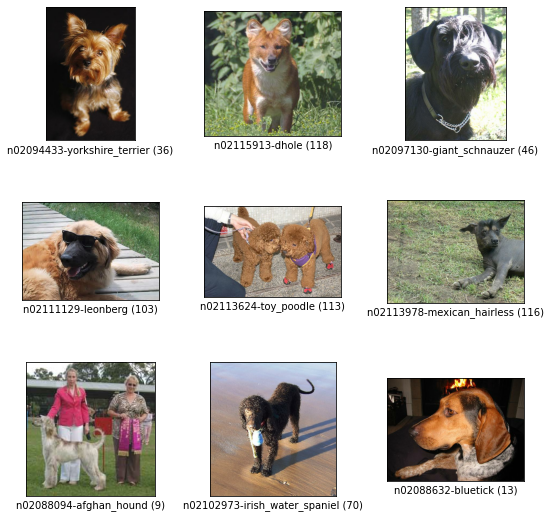

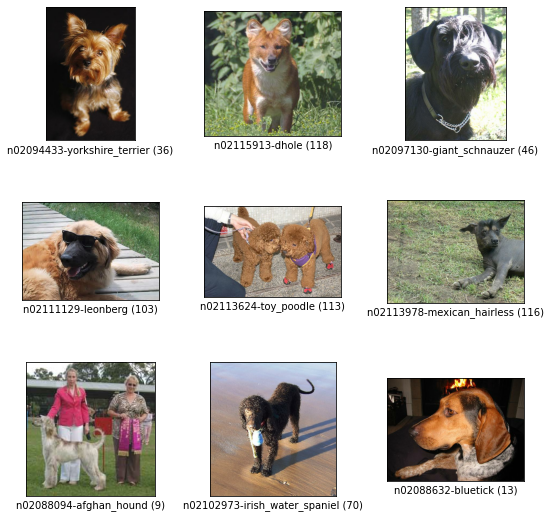

In [16]:
# 데이터셋 확인

tfds.show_examples(ds_train, ds_info)

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_plain = apply_normalize_on_dataset(ds_train)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_fancy='cutmix')
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_fancy='mixup')
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기

In [18]:
# keras의 ResNet50을 불러오기
# No Augmentation
# weights='imagenet'
# include_top=False

num_classes = ds_info.features["label"].num_classes
plain_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax') 
        # 마지막 레이어만 이번 케이스에 맞게 추가
])

94773248/94765736 [==============================] - 1s 0us/step


In [19]:
# imgagu Augmentation ResNet

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
# Augmentation + cutmix ResNet
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [21]:
# Augmentation + mixup ResNet
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기

In [22]:
EPOCH = 20

In [23]:
# No Augmentation

plain_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_plain = plain_resnet50.fit(
    ds_train_plain, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 346s 423ms/step - loss: 3.1870 - accuracy: 0.2799 - val_loss: 3.1116 - val_accuracy: 0.2452
Epoch 2/20
750/750 [==============================] - 321s 428ms/step - loss: 0.8934 - accuracy: 0.7506 - val_loss: 1.1527 - val_accuracy: 0.6607
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.2775 - accuracy: 0.9413 - val_loss: 0.9766 - val_accuracy: 0.7162
Epoch 4/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0791 - accuracy: 0.9923 - val_loss: 0.9223 - val_accuracy: 0.7315
Epoch 5/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0307 - accuracy: 0.9985 - val_loss: 0.9289 - val_accuracy: 0.7344
Epoch 6/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0171 - accuracy: 0.9998 - val_loss: 0.9623 - val_accuracy: 0.7298
Epoch 7/20
750/750 [==============================] - 324s 433ms/step - loss: 0.0123 - accuracy: 0.9998 - val_loss: 0.9489 -

In [24]:
# imgaug + Augmentation

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 332s 435ms/step - loss: 3.2736 - accuracy: 0.2678 - val_loss: 2.8189 - val_accuracy: 0.2935
Epoch 2/20
750/750 [==============================] - 326s 434ms/step - loss: 1.0869 - accuracy: 0.6853 - val_loss: 1.1229 - val_accuracy: 0.6652
Epoch 3/20
750/750 [==============================] - 326s 435ms/step - loss: 0.5841 - accuracy: 0.8438 - val_loss: 1.0607 - val_accuracy: 0.6917
Epoch 4/20
750/750 [==============================] - 325s 434ms/step - loss: 0.2974 - accuracy: 0.9274 - val_loss: 1.0676 - val_accuracy: 0.6968
Epoch 5/20
750/750 [==============================] - 326s 434ms/step - loss: 0.1526 - accuracy: 0.9720 - val_loss: 1.1067 - val_accuracy: 0.6945
Epoch 6/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0914 - accuracy: 0.9862 - val_loss: 0.9698 - val_accuracy: 0.7282
Epoch 7/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0573 - accuracy: 0.9914 - val_loss: 0.9750 -

In [25]:
# imgaug + cutmix

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 333s 436ms/step - loss: 4.4006 - accuracy: 0.1030 - val_loss: 2.9404 - val_accuracy: 0.2727
Epoch 2/20
750/750 [==============================] - 326s 435ms/step - loss: 3.1631 - accuracy: 0.3680 - val_loss: 1.4908 - val_accuracy: 0.5787
Epoch 3/20
750/750 [==============================] - 327s 436ms/step - loss: 2.8277 - accuracy: 0.4640 - val_loss: 1.3420 - val_accuracy: 0.6195
Epoch 4/20
750/750 [==============================] - 327s 437ms/step - loss: 2.6467 - accuracy: 0.5168 - val_loss: 1.3021 - val_accuracy: 0.6461
Epoch 5/20
750/750 [==============================] - 327s 436ms/step - loss: 2.5161 - accuracy: 0.5708 - val_loss: 1.4924 - val_accuracy: 0.5971
Epoch 6/20
750/750 [==============================] - 327s 436ms/step - loss: 2.3869 - accuracy: 0.6110 - val_loss: 1.1226 - val_accuracy: 0.6876
Epoch 7/20
750/750 [==============================] - 326s 435ms/step - loss: 2.2804 - accuracy: 0.6392 - val_loss: 1.1801 -

In [26]:
# imgaug + mixup

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 332s 435ms/step - loss: 4.3517 - accuracy: 0.1168 - val_loss: 3.4113 - val_accuracy: 0.2127
Epoch 2/20
750/750 [==============================] - 326s 435ms/step - loss: 3.0372 - accuracy: 0.4204 - val_loss: 1.4045 - val_accuracy: 0.5961
Epoch 3/20
750/750 [==============================] - 326s 435ms/step - loss: 2.7353 - accuracy: 0.5265 - val_loss: 1.2484 - val_accuracy: 0.6427
Epoch 4/20
750/750 [==============================] - 327s 436ms/step - loss: 2.5848 - accuracy: 0.5716 - val_loss: 1.1786 - val_accuracy: 0.6651
Epoch 5/20
750/750 [==============================] - 326s 435ms/step - loss: 2.4810 - accuracy: 0.6267 - val_loss: 1.3109 - val_accuracy: 0.6395
Epoch 6/20
750/750 [==============================] - 327s 436ms/step - loss: 2.3378 - accuracy: 0.6753 - val_loss: 1.1663 - val_accuracy: 0.6687
Epoch 7/20
750/750 [==============================] - 327s 436ms/step - loss: 2.2416 - accuracy: 0.7043 - val_loss: 1.1996 -

## 4. 훈련 과정 시각화

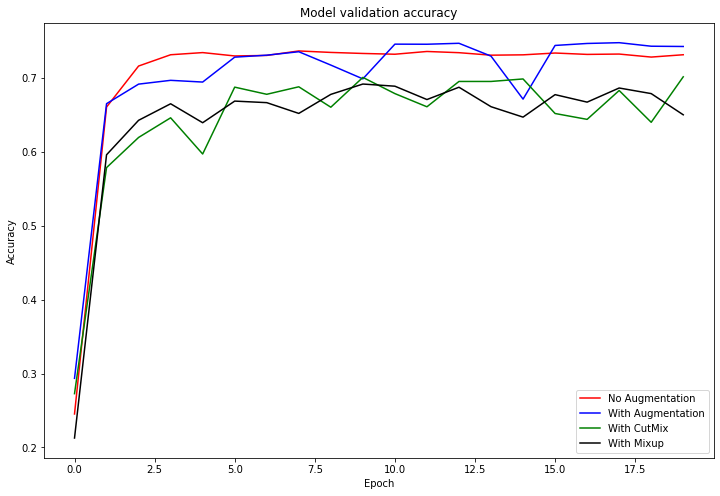

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_plain.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'])
plt.show()

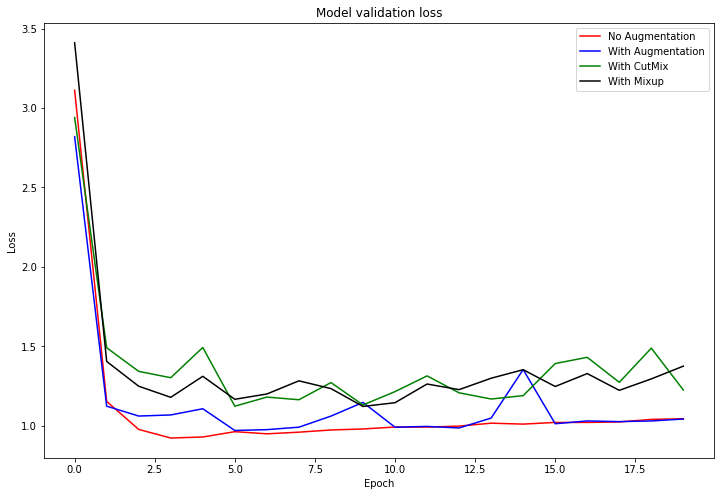

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_plain.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'])
plt.show()